VAE　オートエンコーダー

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [ ]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更してね。

In [ ]:
%cd "ctorch210824/MiniCTorch_Prototype"

/content/drive/My Drive/Colab Notebooks/ctorch210824/MiniCTorch_Prototype


In [ ]:
! pip install lark-parser

     |████████████████████████████████| 229 kB 31.3 MB/s 
  Created wheel for lark-parser: filename=lark_parser-0.11.3-py2.py3-none-any.whl size=99740 sha256=ad53399d2367cbf9b7f7ee3409e6c139b02c961a994fac6d57bc3b732858212c
  Stored in directory: /root/.cache/pip/wheels/2d/f0/65/7aea47a49de7acac0108aac16a7ee00eb996f872d978feb87e
Successfully built lark-parser


In [ ]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

In [ ]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()

サンプルデータの図化

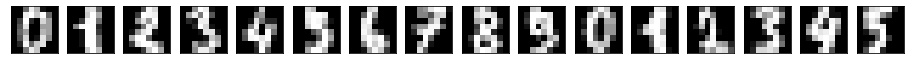

In [ ]:
import matplotlib.pyplot as plt
n_img = 16

plt.figuｒe( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [ ]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;

def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = e.sum() / len(y)
  return z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * g.sum() / len(mean)
  return y

import torch.distributions as tdist

class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    self.eps = e
  
  def forward( self, x ):
    # encoder
    x2 = F.relu( self.fc1(x) )
    self.mean    = self.fc2_mean(x2)
    self.log_var = self.fc2_var(x2)

    # reparametrization
    #print(self.mean.shape)
    eps = torch.randn( self.mean.shape, device="cpu" )
    #z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )
    #z = self.mean + 0.5 * torch.exp( 0.5 * self.log_var )

    #eps = torch.randn( n_batch, n_z )
    #eps = torch.randn( self.mean.shape )
    #print("mean",self.mean)
    #print("mean",self.mean.size())
    #nm = tdist.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal(0.0,1.0,[32,2])
    #print("eps",eps.size())
    #print("eps",eps)
    z = self.mean + eps * torch.exp( 0.5 * self.log_var )
    #z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

    # decoder
    y = F.relu( self.fc3(z) )
    y = torch.sigmoid( self.fc4(y) )
    ##return y
    
    e1 = reconstruction( y, x )
    e2 = kl_divergence( self.mean, self.log_var )
    
    """
    print("x.shape",x.shape)
    print("y.shape",y.shape)
    print("mean.shape",self.mean.shape)
    print("var.shape",self.log_var.shape)
    print("x",x)
    print("y",y)
    print("mean",self.mean)
    print("var",self.log_var)
    print("e1",e1)
    print("e2",e2)
    """
    return -(e1+e2)
    

In [ ]:
def generate_json( json_path, input, e ):

    model = Net( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [ ]:
torch.manual_seed( 1 )

project = 'vae1'
json_path = 'network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
#print(x.shape)
x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

model = generate_json( json_path, x, e )

with torch.set_grad_enabled(True):
  model.eval()
  output = model( x )
  print("output",output)
  #output.sum().backward()
  output.backward()
  #print("fc1_w",model.fc1.weight.grad)
  #print("fc1_b",model.fc1.bias.grad)
  #print("fc1_rx",model.fc1)
  #print("fc1_z",model.rz.grad)
  """
  print("fc2_mean_w",model.fc2_mean.weight.grad)
  print("fc2_mean_b",model.fc2_mean.bias.grad)
  print("fc2_var_w",model.fc2_var.weight.grad)
  print("fc2_var_b",model.fc2_var.bias.grad)
  """
  #print("output",output.grad)
  print("input_grad",x.grad)

[SAVE] network/vae1.json
skip: Net/Linear[fc1]/weight/104
skip: Net/Linear[fc1]/weight/104
skip: Net/Linear[fc2_mean]/weight/107
skip: Net/Linear[fc2_mean]/weight/107
skip: Net/Linear[fc2_var]/weight/110
skip: Net/Linear[fc2_var]/weight/110
skip: Net/Linear[fc3]/weight/113
skip: Net/Linear[fc3]/weight/113
skip: Net/Linear[fc4]/weight/116
skip: Net/Linear[fc4]/weight/116
output tensor(45.1495, grad_fn=<NegBackward>)
input_grad tensor([[-0.0050,  0.0045, -0.0101,  ..., -0.0009, -0.0027,  0.0052],
        [-0.0097,  0.0096, -0.0162,  ..., -0.0040, -0.0035,  0.0061],
        [-0.0067,  0.0045, -0.0166,  ..., -0.0063, -0.0080,  0.0040],
        ...,
        [-0.0070,  0.0067, -0.0158,  ..., -0.0049, -0.0066,  0.0048],
        [-0.0086,  0.0176, -0.0294,  ..., -0.0088, -0.0133,  0.0054],
        [-0.0086,  0.0026, -0.0065,  ...,  0.0042, -0.0036,  0.0108]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  


In [ ]:
"""
def convert_json( project, folder, model, input_x, json_path, rand_flag=0 ):

    #folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )
"""
CV.convert_json( project, "src", model, x, json_path )

[JSON] network/vae1.json
{'name': 'Net/Linear[fc1]/weight/128', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/127', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2_mean]/weight/131', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2_mean]/bias/130', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc2_var]/weight/134', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [11], 'sorted_id': 9}
{'name': 'Net/Linear[fc2_var]/bias/133', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [11], 'sorted_id': 10}
{'name': 'Net/Linear[fc3]/weight/137', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [20], 'sorted_id': 18}
{'name': 'Net/Linear[fc3]/bias/136', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [20], 'sorted_id': 19}
{'name': 'Net/Linear[fc4]/weight/140', 'op': 'prim::Ge

In [ ]:
!g++ -std=c++14 ./src/vae1.cpp ./src/vae1_param.cpp -I ../../ctorch/lib -lcblas -o ./bin/vae1

(注意) ctorch/libにxtensor関連のincludeを置いています。

In [ ]:
!./bin/vae1

### forward computation ...
{ 45.149506}
### backward computation ...
input_grad{{-0.005013,  0.004498, -0.010097, ..., -0.000856, -0.002696,  0.005182},
 {-0.00967 ,  0.009581, -0.016173, ..., -0.003957, -0.003504,  0.006057},
 {-0.006696,  0.004511, -0.016579, ..., -0.006288, -0.008011,  0.003987},
 ..., 
 {-0.00702 ,  0.006713, -0.015817, ..., -0.004912, -0.006611,  0.004784},
 {-0.008582,  0.017581, -0.029435, ..., -0.008818, -0.013347,  0.005445},
 {-0.008566,  0.002597, -0.006499, ...,  0.004227, -0.003623,  0.010843}}


In [ ]:
torch.manual_seed( 1 )

project = 'vae1'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
#print(x.shape)
x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr=0.01
opt = torch.optim.SGD(net.parameters(), lr)
#mse = torch.nn.MSELoss()

epoch_loss = []
epoch_num = 1000; #201
for epoch in range(epoch_num):

  loss = net( x )

  print("loss",loss)

  opt.zero_grad()
  loss.backward()
  #print("fc1_w",model.fc1.weight.grad)
  #print("fc1_b",model.fc1.bias.grad)
  #print("fc1_rx",model.fc1)
  #print("fc1_z",model.rz.grad)
  """
  print("fc2_mean_w",model.fc2_mean.weight.grad)
  print("fc2_mean_b",model.fc2_mean.bias.grad)
  print("fc2_var_w",model.fc2_var.weight.grad)
  print("fc2_var_b",model.fc2_var.bias.grad)
  """
  #print("output",output.grad)

  opt.step()
  print("EPOCH: {} loss: {}".format(epoch, loss))
  epoch_loss.append( loss )
 

loss tensor(44.9811, grad_fn=<NegBackward>)
EPOCH: 0 loss: 44.98109817504883
loss tensor(45.1398, grad_fn=<NegBackward>)
EPOCH: 1 loss: 45.13983154296875
loss tensor(44.7923, grad_fn=<NegBackward>)
EPOCH: 2 loss: 44.792320251464844
loss tensor(44.3199, grad_fn=<NegBackward>)
EPOCH: 3 loss: 44.3199462890625
loss tensor(44.0797, grad_fn=<NegBackward>)
EPOCH: 4 loss: 44.07967758178711
loss tensor(43.8538, grad_fn=<NegBackward>)
EPOCH: 5 loss: 43.85380554199219
loss tensor(43.5098, grad_fn=<NegBackward>)
EPOCH: 6 loss: 43.50981903076172
loss tensor(43.4258, grad_fn=<NegBackward>)
EPOCH: 7 loss: 43.425846099853516
loss tensor(43.4149, grad_fn=<NegBackward>)
EPOCH: 8 loss: 43.414878845214844
loss tensor(42.9851, grad_fn=<NegBackward>)
EPOCH: 9 loss: 42.98505783081055
loss tensor(42.5460, grad_fn=<NegBackward>)
EPOCH: 10 loss: 42.546043395996094
loss tensor(42.4692, grad_fn=<NegBackward>)
EPOCH: 11 loss: 42.46922302246094
loss tensor(42.1893, grad_fn=<NegBackward>)
EPOCH: 12 loss: 42.18930816

学習の収束の図化 (python)

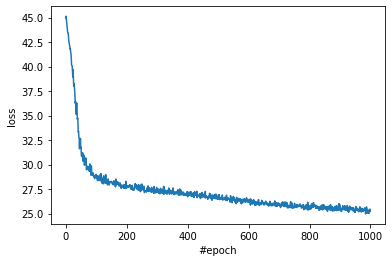

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

In [ ]:
import torch.distributions as tdist

n = tdist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

e = n.sample((n_mid,))

In [ ]:
e

tensor([[ 0.5516],
        [-1.4746],
        [-1.2032],
        [-0.4709],
        [ 1.0430],
        [-0.9447],
        [ 0.7663],
        [-0.8108],
        [-0.7571],
        [ 0.6683],
        [-0.9177],
        [-0.1356],
        [-0.8786],
        [ 3.5638],
        [-1.4244],
        [-0.5050]])

In [ ]:
e2= torch.randn(n_mid)
print(e2)

tensor([ 1.4625,  0.0852,  0.2403, -0.7425, -1.1566, -1.9472, -0.0739,  1.4408,
        -1.5811,  0.1749,  1.1583,  0.6945, -0.4813, -0.2892,  1.3323, -0.9172])
